In [1]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.5 MB/s eta 0:00:00:00:0100:01
Creating new Ultralytics

In [2]:
%cd /kaggle/working

!mkdir -p coco
%cd coco

# val2017 images + annotations (5k images)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

/kaggle/working
/kaggle/working/coco


In [3]:
import os, json, random, shutil
from pathlib import Path
from collections import defaultdict
from PIL import Image

random.seed(42)

# === Paths ===
SRC_IMG = "/kaggle/working/coco/val2017"
ANN_FILE = "/kaggle/working/coco/annotations/instances_val2017.json"
ROOT = "/kaggle/working/coco_person"

# target dirs
train_img_dir = os.path.join(ROOT, "images", "train")
val_img_dir   = os.path.join(ROOT, "images", "val")
train_lbl_dir = os.path.join(ROOT, "labels", "train")
val_lbl_dir   = os.path.join(ROOT, "labels", "val")

for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# === Load COCO annotations ===
with open(ANN_FILE, "r") as f:
    coco = json.load(f)

imgs = coco["images"]
anns = coco["annotations"]
cats = coco["categories"]

# Person class id in COCO JSON
PERSON_CAT_ID = 1

# Group annotations per image (only persons)
per_image = defaultdict(list)
for a in anns:
    if a["category_id"] == PERSON_CAT_ID:
        per_image[a["image_id"]].append(a)

# Get only images that have at least one person
person_imgs = [im for im in imgs if im["id"] in per_image]
all_imgs = [im["file_name"] for im in person_imgs]
print(f"Total person images: {len(all_imgs)}")

# === Split images (only positive) ===
random.shuffle(all_imgs)
split_idx = int(0.8 * len(all_imgs))
train_imgs, val_imgs = all_imgs[:split_idx], all_imgs[split_idx:]

for fn in train_imgs:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(train_img_dir, fn))
for fn in val_imgs:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(val_img_dir, fn))

print(f"Train imgs: {len(train_imgs)}, Val imgs: {len(val_imgs)}")

# === Generate YOLO labels ===
def gen_labels(img_list, img_dir, lbl_dir):
    written = 0
    for fname in img_list:
        img = next(im for im in imgs if im["file_name"] == fname)
        anns = per_image.get(img["id"], [])
        if not anns:
            continue  # we already filtered, but safe
        W, H = img["width"], img["height"]
        lines = []
        for a in anns:
            x,y,w,h = a["bbox"]
            xc = (x + w/2) / W
            yc = (y + h/2) / H
            wn = w / W
            hn = h / H
            lines.append(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        with open(os.path.join(lbl_dir, Path(fname).stem + ".txt"), "w") as f:
            f.write("\n".join(lines))
        written += 1
    return written

t_written = gen_labels(train_imgs, train_img_dir, train_lbl_dir)
v_written = gen_labels(val_imgs, val_img_dir, val_lbl_dir)

print(f"Labels written -> train: {t_written}, val: {v_written}")


Total person images: 2693
Train imgs: 2154, Val imgs: 539
Labels written -> train: 2154, val: 539


In [4]:
yaml_text = f"""
path: {ROOT}
train: images/train
val: images/val
nc: 1
names: [person]
"""
with open("/kaggle/working/person.yaml", "w") as f:
    f.write(yaml_text)

In [5]:
from ultralytics import RTDETR
model = RTDETR("rtdetr-l.pt")  

model.train(
    data="/kaggle/working/person.yaml",  
    epochs=100,       
    imgsz=640,
    batch=16,         
    workers=2
)

Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/person.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100      12.3G     0.6439     0.8773     0.2981         83        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:250.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.2s0.6s
                   all        539       2301      0.717      0.496      0.549      0.342

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/100      12.5G       0.64     0.6151     0.3127         78        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.644      0.484      0.536      0.305

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/100      12.2G     0.6535     0.6811     0.3211         54        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:361.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.1s0.7s
                   all        539       2301      0.434      0.282      0.254      0.126

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/100      12.4G     0.7056     0.6979     0.3514         41        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 11.0s0.7s
                   all        539       2301      0.512      0.369      0.379      0.203

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/100      12.4G     0.7199     0.7679     0.3379         88        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:361.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.534       0.31      0.346      0.183

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/100      12.5G     0.7271     0.7425     0.3531         68        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 11.0s0.7s
                   all        539       2301      0.535      0.299      0.308      0.166

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/100      12.4G      0.658      0.729     0.3078         92        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.618      0.488      0.518      0.295

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/100      12.4G      0.639     0.7199     0.2984         59        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.5s0.6s
                   all        539       2301      0.425      0.163      0.146     0.0813

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/100      12.6G     0.7342      0.715     0.3801         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.483      0.383      0.365      0.208

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/100      12.5G     0.6598     0.7125     0.3071         71        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.598      0.467      0.478      0.267

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/100      12.3G     0.6114     0.7073     0.2883         70        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301       0.64      0.437      0.497      0.281

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/100      12.5G     0.6277     0.7019     0.2901         42        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.5s0.6s
                   all        539       2301      0.195     0.0704     0.0492     0.0233

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/100      11.9G     0.6344     0.7135     0.2906         62        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.8s0.6s
                   all        539       2301      0.568       0.35       0.37       0.21

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/100      12.4G     0.6305     0.6918     0.2895         46        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:351.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.9s0.6s
                   all        539       2301        0.6      0.393      0.423      0.239

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/100      12.7G     0.6087     0.6843     0.2895         53        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.646      0.463      0.512      0.291

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/100      12.3G     0.6378     0.6828     0.2972         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.583      0.399      0.433      0.234

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/100      12.4G     0.6531     0.7105     0.3052         43        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.595      0.433      0.473      0.271

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/100      12.1G     0.6457     0.6948     0.2953         56        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.3s.6s
                   all        539       2301      0.381      0.185      0.166     0.0915

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/100      12.7G     0.6709     0.7354      0.321         59        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.573      0.419      0.459      0.256

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/100      12.3G     0.6663     0.7442     0.3235         55        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.546      0.413      0.427       0.24

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/100      12.2G     0.6465     0.7233     0.3123         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.598      0.461      0.487      0.263

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/100      12.5G     0.6305     0.7062      0.294         53        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.6s
                   all        539       2301      0.622      0.476      0.522      0.296

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/100      12.3G     0.6244     0.7086     0.2905        109        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:341.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.6it/s 10.8s0.6s
                   all        539       2301      0.596      0.376      0.417      0.228

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/100        12G      0.621     0.6943      0.287         82        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.673      0.495      0.566      0.336

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/100      12.5G     0.5942     0.6731     0.2815         83        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.0s0.7s
                   all        539       2301      0.662      0.522      0.586      0.349

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/100      12.4G        nan        nan        nan         51        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/100      12.8G     0.5831     0.6676     0.2667         59        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/100      12.6G     0.5642     0.6659     0.2605         36        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/100      12.2G     0.5806     0.6487     0.2526         55        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/100      12.4G     0.5535     0.6438      0.256         25        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/100      12.6G     0.5608      0.666      0.257        101        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:331.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/100      12.4G        nan        nan        nan         84        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/100      12.3G     0.5681     0.6654     0.2577         68        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/100      12.1G     0.5524     0.6557     0.2533         34        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/100      12.2G     0.5556      0.649     0.2524         54        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/100      12.5G     0.5499     0.6532     0.2523         69        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/100      12.3G     0.5444     0.6491     0.2441         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/100      12.3G     0.5533     0.6424     0.2532         64        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     39/100      12.7G     0.5491     0.6476     0.2473         42        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     40/100      12.6G     0.5293     0.6408     0.2414         71        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     41/100      12.4G     0.5582     0.6325     0.2433        125        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     42/100      12.5G        nan        nan        nan         59        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:321.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     43/100      12.5G        nan        nan        nan         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:260.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     44/100      12.7G        nan        nan        nan         60        640: 100% ━━━━━━━━━━━━ 135/135 1.0it/s 2:210.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     45/100      12.2G        nan        nan        nan         35        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:230.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     46/100      12.4G     0.7851     0.9328     0.4029         55        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     47/100      12.3G     0.7758     0.9419     0.4019         72        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     48/100      12.4G     0.7969     0.9299     0.3999         71        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     49/100      12.5G     0.7941     0.9295     0.4166         54        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     50/100      12.1G     0.7817     0.9307     0.4082         39        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     51/100      12.5G     0.7766     0.9435      0.395         49        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:241.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     52/100      12.6G     0.7799     0.9459     0.4083         47        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     53/100      12.5G     0.7678     0.9504     0.3932         56        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     54/100      12.4G     0.7734     0.9541     0.3984         52        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     55/100      12.6G     0.7872     0.9577     0.4027         71        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     56/100      12.6G     0.7792     0.9362     0.4008         45        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     57/100      12.2G     0.7795     0.9454     0.4121         53        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     58/100      12.4G      0.801     0.9316     0.4116         57        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     59/100      12.5G     0.7745     0.9566      0.399         60        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     60/100      12.5G     0.7834     0.9316     0.4035         61        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     61/100      12.2G      0.776     0.9542     0.4164         59        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     62/100      12.2G     0.7696     0.9329     0.4015         61        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     63/100      12.7G      0.783     0.9546     0.4213         71        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     64/100      12.5G     0.7907      0.943     0.4127         62        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     65/100      12.5G     0.7879     0.9395     0.4111         60        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     66/100      12.4G     0.7717     0.9391     0.3925         99        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     67/100      12.6G       0.77     0.9518     0.3936         48        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     68/100      12.4G     0.7789     0.9414     0.4036        113        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     69/100      12.4G     0.7681      0.946     0.3958         82        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     70/100      12.5G     0.7844     0.9364     0.4091         47        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     71/100      12.6G     0.7678     0.9495     0.3997         46        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     73/100      12.5G     0.7686     0.9491     0.4126         61        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     74/100      12.4G     0.7701     0.9473     0.3904         94        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     75/100      12.6G     0.7809     0.9447     0.4058         81        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     76/100      12.5G     0.7768     0.9522     0.3937         47        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     77/100      12.7G      0.794     0.9303     0.4027         55        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     78/100      12.4G     0.7866     0.9393     0.4009         74        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     79/100      12.5G     0.7829     0.9513     0.4177         75        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     80/100      12.5G     0.7793     0.9455      0.403         65        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     81/100      12.6G     0.7936     0.9219     0.4086         50        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     82/100      12.2G     0.7823     0.9413     0.4034         52        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     83/100        12G     0.7849     0.9415     0.3981         63        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     84/100      12.7G     0.7743     0.9414     0.3924         41        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     85/100      12.4G     0.7839     0.9323     0.4037         73        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     86/100      12.2G     0.7766     0.9364     0.3957         70        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     87/100      12.2G        nan        nan        nan         48        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     88/100      12.4G     0.7957     0.9374      0.413         66        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     89/100      12.4G     0.7799     0.9664     0.4269         49        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     90/100      12.5G     0.7703     0.9501     0.4005         54        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     91/100      12.3G     0.7716      1.249     0.4988         37        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     92/100      12.6G      0.767      1.246     0.4973         33        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     93/100      12.5G     0.7734      1.238     0.5058         37        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     94/100      12.6G     0.7764      1.238     0.5011         43        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     95/100      12.5G      0.764      1.241     0.4868         32        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     96/100      12.6G      0.778      1.231     0.5146         42        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.8s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     97/100      12.2G     0.7771      1.242     0.5258         57        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     98/100      12.5G       0.77      1.264     0.5021         18        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     99/100      12.6G     0.7769      1.236     0.4921         36        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    100/100      12.6G     0.7791       1.25     0.5204         19        640: 100% ━━━━━━━━━━━━ 135/135 0.9it/s 2:240.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.7it/s 9.9s0.6s
                   all        539       2301          0          0          0          0

100 epochs completed in 4.436 hours.
Optimizer stripped from /kaggle/working/coco/runs/detect/train/weights/last.pt, 66.1MB
Optimizer stripped from /kaggle/working/coco/runs/detect/train/weights/best.pt, 66.1MB

Validating /kaggle/working/coco/runs/detect/train/weights/best.pt...
Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.5it/s 11.5s0.6s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        539       2301       0.66      0.523      0.585      0.349
Speed: 0.2ms preprocess, 16.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/coco/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df56556a610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2613.2±509.1 MB/s, size: 174.2 KB)
val: Scanning /kaggle/working/coco_person/labels/val.cache... 539 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 539/539 1.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 1.4it/s 23.5s0.7ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        539       2301      0.665      0.522      0.585      0.349
Speed: 0.7ms preprocess, 39.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /kaggle/working/coco/runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df57f62d1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,

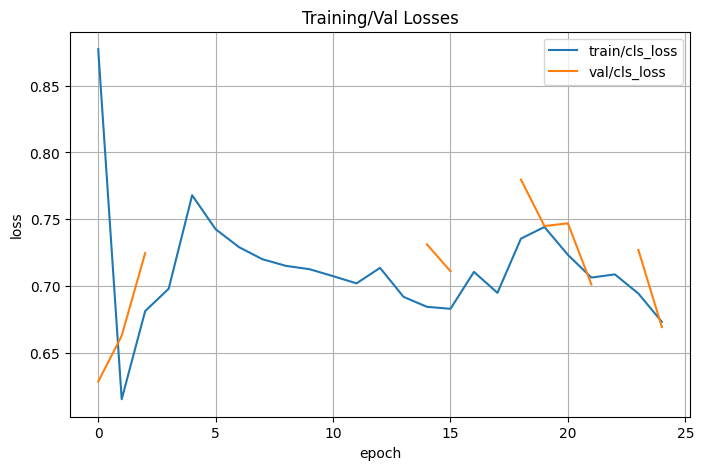

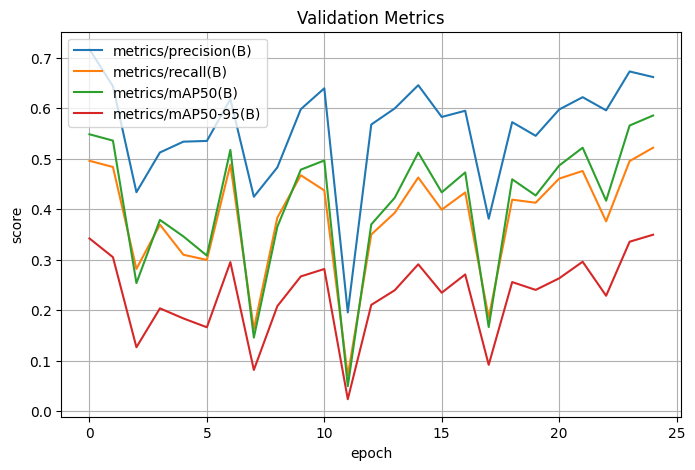

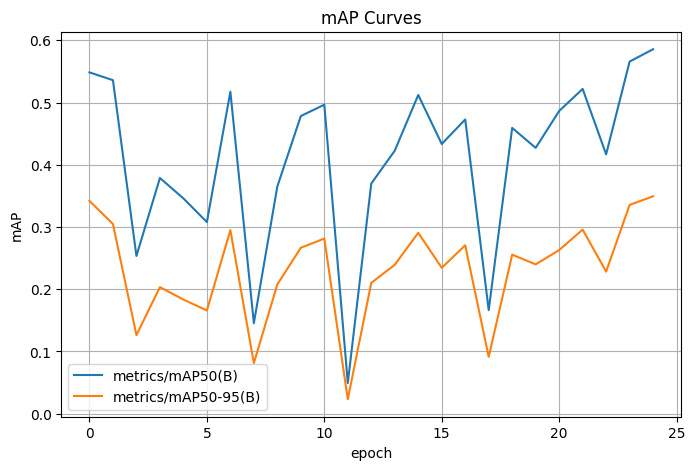

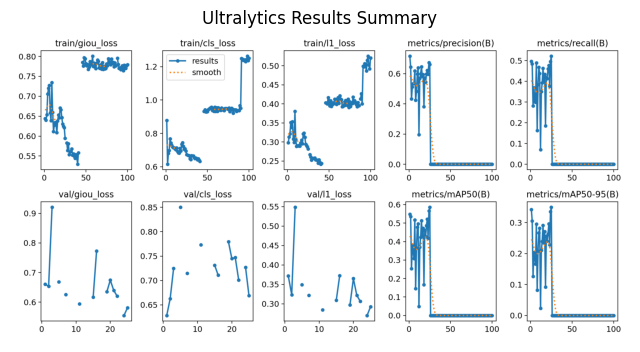

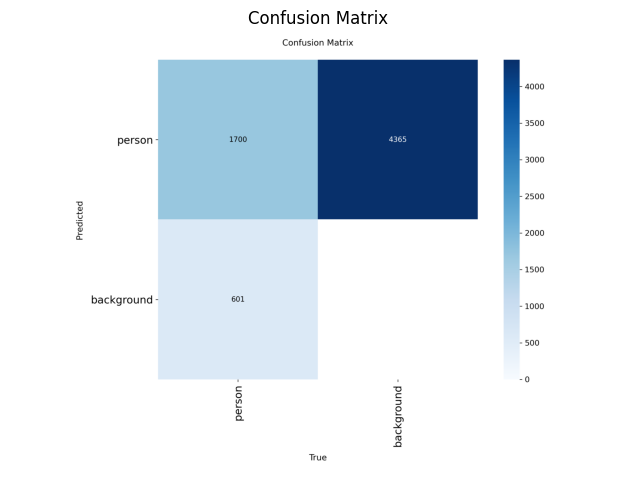


Final epoch metrics (from trimmed results.csv):
  metrics/precision(B): 0.6621
  metrics/recall(B): 0.5220
  metrics/mAP50(B): 0.5858
  metrics/mAP50-95(B): 0.3494


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

CSV_PATH = "/kaggle/working/coco/runs/detect/train/results.csv"
RUN_DIR  = os.path.dirname(CSV_PATH)

# --- load ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"results.csv not found at: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# --- trim trailing zero rows (common with interrupted/early-stopped runs) ---
metric_cols_pref = [
    "metrics/precision(B)","metrics/recall(B)",
    "metrics/mAP50(B)","metrics/mAP50-95(B)",
    "precision","recall","mAP50","mAP50-95"
]
present_metrics = [c for c in metric_cols_pref if c in df.columns]
if present_metrics:
    nz_mask = (df[present_metrics].abs().sum(axis=1) > 0)
    if nz_mask.any():
        last_nz = nz_mask[::-1].idxmax()
        df = df.loc[:last_nz].reset_index(drop=True)

# --- small plot helper ---
def plot_series(dframe, cols, title, ylabel):
    cols = [c for c in cols if c in dframe.columns]
    if not cols: 
        print(f"(skip) {title} — columns not found")
        return
    plt.figure(figsize=(8,5))
    for c in cols:
        plt.plot(dframe.index, dframe[c], label=c)
    plt.title(title)
    plt.xlabel("epoch"); plt.ylabel(ylabel)
    plt.legend(); plt.grid(True); plt.show()

# --- plots ---
loss_cols = [
    "train/box_loss","train/cls_loss","train/dfl_loss",
    "box_loss","cls_loss","dfl_loss",
    "val/box_loss","val/cls_loss","val/obj_loss"
]
plot_series(df, loss_cols, "Training/Val Losses", "loss")

val_cols = [
    "metrics/precision(B)","metrics/recall(B)",
    "metrics/mAP50(B)","metrics/mAP50-95(B)",
    "precision","recall","mAP50","mAP50-95"
]
plot_series(df, val_cols, "Validation Metrics", "score")

map_cols = ["metrics/mAP50(B)","metrics/mAP50-95(B)","mAP50","mAP50-95"]
plot_series(df, map_cols, "mAP Curves", "mAP")

# --- show Ultralytics summary images if they exist ---
def show_if_exists(fname, title=None, size=(8,6)):
    path = os.path.join(RUN_DIR, fname)
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=size)
        plt.imshow(img); plt.axis("off")
        if title: plt.title(title)
        plt.show()

show_if_exists("results.png", "Ultralytics Results Summary")
show_if_exists("PR_curve.png", "Precision–Recall Curve")
show_if_exists("F1_curve.png", "F1 Curve")
show_if_exists("P_curve.png", "Precision Curve")
show_if_exists("R_curve.png", "Recall Curve")
show_if_exists("confusion_matrix.png", "Confusion Matrix")

# --- print final (trimmed) metrics ---
final_keys = [k for k in val_cols if k in df.columns]
if final_keys:
    last = df.iloc[-1]
    print("\nFinal epoch metrics (from trimmed results.csv):")
    for k in final_keys:
        try:
            print(f"  {k}: {float(last[k]):.4f}")
        except Exception:
            print(f"  {k}: {last[k]}")
else:
    print("\nNo validation metric columns found in results.csv")


In [15]:
import shutil

best = "runs/detect/train/weights/best.pt"  
dst = "/kaggle/working/re_detr.pt"
shutil.copy(best, dst)
print(f"✅ Saved best weights to {dst}")
!zip -j model_export2.zip /kaggle/working/re_detr.pt /kaggle/working/person.yaml


✅ Saved best weights to /kaggle/working/re_detr.pt
  adding: re_detr.pt (deflated 8%)
  adding: person.yaml (deflated 16%)
